# Predicting California Wildfires 2013-2018

## Overview

This project's aim is to build a classification model that will predict if there will be a fire in given county over the course of that week. This will be done by using wildfire incidents from Kaggle, and combining it with data about fuel sources by using ground cover data, topography by using elevation data and weather data from CIMIS and Weather Underground. Predicting the weekly probability of wildfires can provide early warning to government groups like CalFire in fighting the spread of wildfires.

## Business Problem

As of early December, there have been more than 9,500 wildfires that have burned more than 4 million acres of California land. California has about 100 million acres, so nearly 4% of California's land has burned from wildfires in the year 2020. This makes 2020 the most destructive year of wildfires recorded in California. Right now the government group CalFire has a Red Flag and Fire Watch Warning system which is issued during forecasted weather events 24-72 hours in advance, which may result in wildfire behavior. The model in this project would predict the probabilities of a wildfire occuring in a county of California during a specific week based on the three main factors that affect wildfire behavior: weather, topography, and fuels. CalFire could use this model in addition to their warning system to better allocate funds and personnel to counties in more danger of wildfire incidents, and thus better control the spread of wildfires that do start.

## Data Understanding

The data set used in the modeling is gathered from muliple sources. The original wildfire data comes from a Kaggle data set that had over 1600 different incidents between 2013 and 2020 that the government group CalFire managed the containment of. From this data set, the `acres_burned`, `county`, and `Start` date were used in the final data set. From the `Start` and `county` columns we regrouped the data based on a weekly basis per county and `acres_burned` gave our target variable if there was an indicent in that county and week or not. To help predict the probability of wildfire, we used the features that affect wildfire behavior: Fuel, Topography, and Weather.

The Fuel data was gathered from the California Land Use and Ownership Portal by the University of California. Between the years of 2013-2018, each county has a Summary Land Use Statistics csv file for each year. There are 26 different types of land cover, like agriculture use, type of forest, or even barren. All these different files were combined into one dataset that that had number of acres and percentage of county land for each tyoe of landcover. 

The Topography data used the min and max elevations of the counties from the Anyplace America topographic maps.

The Weather Data was gathered from the California Irrigation Management Information System (CIMIS) by the California Department of Water Resources and from the Weather Underground Website. The daily measurements for the following features were grabbed:

- `Avg Air Temp (F)`
- `Max Air Temp (F)`
- `Min Air Temp (F)`
- `Max Rel Hum (%)`
- `Avg Rel Hum (%)`
- `Min Rel Hum (%)`
- `Dew Point (F)`
- `Avg Wind Speed (mph)`
- `Precip (in)`

For each of the features, the previous week's and previous month's averages were created for the final data set.

## Data Prep and Cleaning

To build the final data set for our modeling, we needed to restructure and combine the different data sets into one dataframe.

We first create the final dataframe and add a row for each county for each week between the years 2013-2018.

In [ ]:
final_data = county_week()

We then added the fire incidents to the final dataframe.

In [ ]:
# Import in the fire incidents as a pandas dataframe
fire_incidents = pd.read_csv('data/California_Fire_Incidents.csv')
# Using custom function, split dataframe into counties and find weekly fire incidents
county_fire_df = county_fire(fire_incidents)
# Using custom function, create new dataframe with binary target variable fire_started
fire_started_df = fire_started(county_fire_df)
# Merge the target variable dataframe with final dataframe
final_data = pd.merge(final_data, fire_started, 
                      how = 'left', 
                      left_on = ['county', 'date'], 
                      right_on = ['county', 'date'])

For the fuel data, all the different county land use statistics need to be restructured and put into one dataframe. For ease, the max elevations and min elevations from topography will be merged here as well.

In [ ]:
# Find all the filenames for the ground cover data
files = filenames()
# Import the csv files into pandas dataframes
gc_df_list = import_ground_cover(files)
# Restructure dataframes and merge into on dataframe
gc_df = ground_cover_data(gc_df_list, files)
# Check the first five rows
gc_df.head()

The fuel dataframe is merged with the final dataframe.

In [ ]:
final_data = pd.merge(final_data, gc_df, how = 'left', left_on = ['county', 'year'], right_on = ['county', 'year'])

We want to check for any null values in the final dataframe

In [ ]:
final_data.isna().sum()

The null values in the fuel section are where there is no particular ground cover in that county. Not all the counties grow the same agricultural produce. The null values in the fire started is where there are no fires. This means the null values can be replaced with 0.

In [ ]:
final_data = final_data.fillna(0)

For the weather data, the specific features need to be gathered from the daily weather data from CIMIS and Weather Underground.

In [ ]:
# Use custom function to import CIMIS data and aggregate Past Weeks Weather Averages 
# and Past Months Weather Averages
cimis_pww, cimis_pmw = cimis_data()

# Use custom function to import Weather Underground data and aggregate Past Weeks Weather Averages 
# and Past Months Weather Averages
wu_ppw, wu_pmw = wu_data()

# Use custom function to create a Past Weeks Weather Averages dataframe
pww_df = weekly_data(cimis_pww, wu_ppw)

# Use custom function to create a Past Months Weather Averages dataframe
pmw_df = monthly_data(cimis_pmw, wu_pmw)

# Merge the two weather dataframes
weather_df = pd.merge(pww_df, pmw_df, how = 'left', left_on = ['county', 'date'], right_on = ['county', 'date'])

# Merge weather dataframe with the final dataframe
final_data = pd.merge(final_data, weather_df, how = 'left', left_on = ['county', 'date'], right_on = ['county', 'date'])

We check the final dataframe for any null values

In [ ]:
final_data.isna().sum()

There are four missing values in the past week weather features. Due to there small number, the previous value for the column will be used as the value.

In [ ]:
final_data = final_data.ffill()

We check for any duplicates.

In [ ]:
final_data.duplicated().sum()

## Exploratory Data Analysis

We first take another look at a portion of the data and check the number of columns and their entries. Then check the range of values in the columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_csv('data/california_wildfires.csv')

In [3]:
df.head()

,Unnamed: 0,date,county,year,acres_burned,fire_started,Unnamed: 0.1,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month
0,0,2013-01-06,Alameda,2013,0.0,0.0,2,1102.856805,0.300074,4.225505,0.001150,194.595625,0.052947,4.670295,0.001271,0.000000,0.000000,5.337480,0.001452,7838.756565,2.132827,1536.749450,0.418130,1.779160,0.000484,991.214515,0.269697,3722.447510,1.012831,153671.386680,41.812059,28431.421590,7.735834,39470.886995,10.739534,74885.956375,20.375531,0.0,0.0,8.673405,0.002360,0.0,0.0,0.889580,0.000242,30958.051185,8.423298,4.670295,0.001271,164.127510,0.044657,4.670295,0.001271,19403.518960,5.279454,4497.494085,1.223712,624.485160,0.169915,1242,-42,44.214286,82.785714,2.392857,39.321429,54.157143,96.500000,35.771429,60.785714,0.095714,45.506897,78.189655,2.915517,38.932759,55.896552,95.448276,35.725862,55.810345,0.130172
1,1,2013-01-06,Alpine,2013,0.0,0.0,2,189.035750,0.040080,0.000000,0.000000,15482.472715,3.282650,0.000000,0.000000,0.000000,0.000000,194.595625,0.041259,195088.007530,41.363269,0.444790,0.000094,0.222395,0.000047,0.000000,0.000000,0.000000,0.000000,5644.829890,1.196837,121.427670,0.025746,3192.480225,0.676881,0.667185,0.000141,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,247783.390805,52.535935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2650.503610,0.561969,1297.452430,0.275091,0.000000,0.000000,3556,1442,29.657143,76.514286,3.228571,21.328571,34.428571,91.857143,22.857143,55.428571,0.000000,30.789655,68.162069,4.968966,19.600000,39.344828,86.000000,22.758621,46.344828,0.000000
2,2,2013-01-06,Amador,2013,0.0,0.0,2,1326.808570,0.414290,16.679625,0.005208,1873.010690,0.584840,242.632945,0.075761,0.000000,0.000000,17190.911105,5.367789,114386.866695,35.716810,168.130620,0.052498,12.009330,0.003750,120.093300,0.037499,2587.343430,0.807887,112912.610240,35.256480,440.119705,0.137425,8263.975805,2.580391,1727.119570,0.539286,0.0,0.0,1.334370,0.000417,0.0,0.0,1.111975,0.000347,52457.865415,16.379744,0.000000,0.000000,1.779160,0.000556,122.094855,0.038124,5822.745890,1.818128,105.860020,0.033054,479.483620,0.149717,3121,43,34.114286,83.571429,3.157143,29.585714,40.071429,96.000000,27.757143,66.571429,0.141429,34.289655,76.724138,3.606897,27.410345,41.200000,93.172414,27.768966,58.310345,0.155517
3,3,2013-01-06,Butte,2013,0.0,0.0,2,3777.156680,0.374865,46196.556585,4.584787,1869.452370,0.185534,2023.349710,0.200808,9.118195,0.000905,33181.556395,3.293111,408193.790775,40.511281,56434.510410,5.600855,10563.317710,1.048359,2628.041715,0.260821,247.525635,0.024566,170758.216925,16.946936,4421.6

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18154 entries, 0 to 18153
Data columns (total 79 columns):
Unnamed: 0                             18154 non-null int64
date                                   18154 non-null object
county                                 18154 non-null object
year                                   18154 non-null int64
acres_burned                           18154 non-null float64
fire_started                           18154 non-null float64
Unnamed: 0.1                           18154 non-null int64
Alfalfa & Hay_acres                    18154 non-null float64
Alfalfa & Hay_percentage               18154 non-null float64
Almonds_acres                          18154 non-null float64
Almonds_percentage                     18154 non-null float64
Barren_acres                           18154 non-null float64
Barren_percentage                      18154 non-null float64
Corn_acres                             18154 non-null float64
Corn_percentage                

In [5]:
df.describe()

,Unnamed: 0,year,acres_burned,fire_started,Unnamed: 0.1,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month
count,18154.000000,18154.000000,18154.000000,18154.000000,18154.0,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000
mean,9076.500000,2015.504792,290.232401,0.060207,2.0,24570.424702,2.003151,21117.333652,1.604569,7.912427e+04,2.261803,3361.109941,0.487368,4301.021027,0.299834,8721.068583,0.943632,3.583280e+05,24.659339,28732.768640,2.576118,6684.375969,0.423007,12393.999700,1.138298,14699.487910,1.135835,1.899408e+05,16.148044,29282.398944,3.080043,55036.139529,5.065425,30109.664401,3.599637,543.563136,0.136258,5729.514633,0.281947,460.246269,0.123428,8496.502065,1.438587,7.230996e+05,27.896110,4786.157442,0.502587,5903.129910,0.382318,7075.275829,0.905611,16105.280443,1.250698,9558.657253,1.012787,6877.897718,0.632848,2234.293103,177.568966,59.500787,61.311253,4.934522,44.036920,73.454869,84.207783,46.880363,38.882119,0.039067,59.490712,61.293238,4.942224,44.014769,73.446804,84.200918,46.870562,38.859696,0.039071
std,5240.752729,1.707242,6492.129448,0.237877,0.0,40225.018677,3.263930,49383.509905,3.303131,2.110837e+05,4.160180,8607.274795,1.400160,15051.203943,1.396754,12558.740032,1.658224,4.729540e+05,23.872315,55356.367026,4.962582,20126.287513,0.871029,23313.919454,2.154025,34616.473316,2.206399,2.030533e+05,12.824473,104775.403842,7.999534,75105.921991,6.314707,47163.681669,5.883815,4896.533721,1.214836,18947.612638,0.858020,4589.752379,1.134029,26293.910360,4.767195,1.584942e+06,21.515792,13830.499485,1.204872,16069.686764,0.715188,14845.856636,2.149516,28610.599989,1.369898,14670.268921,1.913291,13477.777082,1.238564,1161.707748,362.743916,12.

It is important to check the number of weeks that have wildfires started and those that don't.

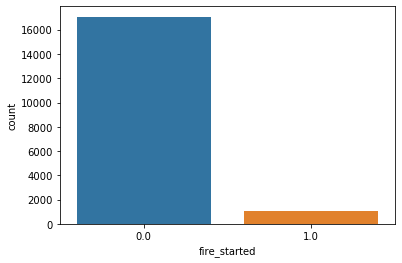

In [7]:
sns.countplot(df.fire_started);

As expected, there is a large class imbalance between the number of weeks that have a wildfire starting and the weeks that don't.

Next we checked the number wildfires through the year. We use only one year to get a clearer idea of possible high points.

In [ ]:
year_ex = year_example(df)
plt.plot(year_ex['date'], year_ex.fire_started);

There are more wildfires starting in the summer months than the rest of the year. This makes sense as the summer months are drier and with less rain.

We create a month feature to take a closer look at the number of wildfires started based on month.

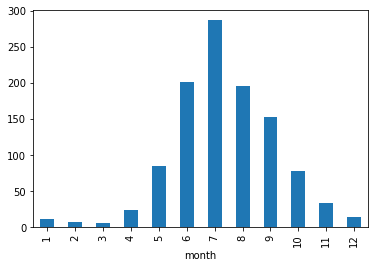

In [8]:
# Create new feature for month of the year
df['month'] = pd.DatetimeIndex(df.date).month
# Group the dataframe by month and the sum of the fires started
month_gpby = df.groupby('month')['fire_started'].sum()
# Plot grouped dataframe
month_gpby.plot(kind = 'bar');

As seen in the year 2013, over the course of 2013-2018 the majority of wildfires start in the summer months. July is the month that has the most wildfires started.

Next we check if there are certain years that have more wildfires than others.

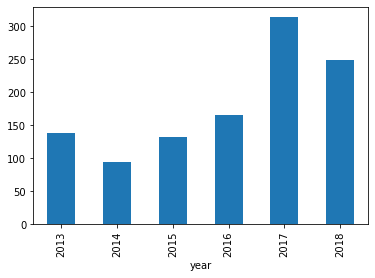

In [9]:
# Group fires started by year
year_gpby = df.groupby('year')['fire_started'].sum()
# Plot grouped dataframe
year_gpby.plot(kind = 'bar');

After the decrease after 2013, there seems to be an increasing trend of wildfires that Calfire managed the containment of.

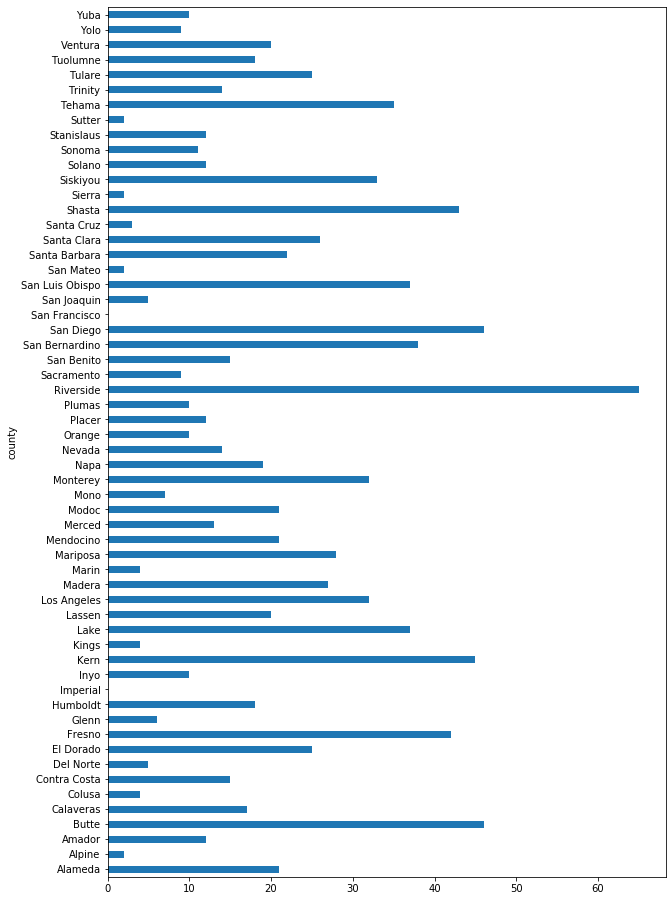

In [10]:
# Group fires by county
county_gpby = df.groupby('county')['fire_started'].sum()
# Plot grouped dataframe
county_gpby.plot(kind = 'barh', figsize = (10, 16));

There are certain counties that are more likely to have more wildfires than others. The county of Riverside has had the highest number of wilfires started.

## Modeling